In [ ]:

import cdsapi
import netCDF4
from netCDF4 import num2date
import numpy as np
import pandas as pd
import os
import time

def telecharger_et_sauver_mensuel_era5(annee, mois, output_dir="./csv_vent_mensuel", pause_sec=60):
    print(f"\n=== Traitement : {annee}-{mois:02d} ===")
    output_csv = os.path.join(output_dir, f"vent_{annee}_{mois:02d}.csv")

    # Sauter si déjà traité
    if os.path.exists(output_csv):
        print(f"⏭ Déjà existant, on saute : {output_csv}")
        return

    nc_path = f"vent_era5_{annee}_{mois:02d}.nc"
    client = cdsapi.Client()

    try:
        client.retrieve(
            'reanalysis-era5-single-levels',
            {
                "product_type": "reanalysis",
                "variable": [
                    "10m_u_component_of_wind",
                    "10m_v_component_of_wind",
                    "100m_u_component_of_wind",
                    "100m_v_component_of_wind",
                    "10m_u_component_of_neutral_wind",
                    "10m_v_component_of_neutral_wind",
                    "instantaneous_10m_wind_gust"
                ],
                "year": str(annee),
                "month": f"{mois:02d}",
                "day": [f"{d:02d}" for d in range(1, 32)],
                "time": [f"{h:02d}:00" for h in range(24)],
                "format": "netcdf",
                "area": [51.5, -5.5, 41.0, 9.5]  # France métropolitaine
            },
            nc_path
        )
    except Exception as e:
        print(f" Erreur de téléchargement {annee}-{mois:02d} : {e}")
        return

    # Lecture NetCDF directement
    try:
        f = netCDF4.Dataset(nc_path)
    except Exception as e:
        print(f" Erreur d'ouverture du fichier .nc : {e}")
        return

    print(" Variables NetCDF :", list(f.variables.keys()))

    try:
        time_var_name = [k for k in f.variables if 'time' in k.lower()][0]
    except IndexError:
        raise KeyError(" Aucune variable temporelle détectée dans le NetCDF.")

    times = num2date(f.variables[time_var_name][:], f.variables[time_var_name].units)
    latitudes = f.variables['latitude'][:]
    longitudes = f.variables['longitude'][:]

    # Construction DataFrame de base
    times_grid, lat_grid, lon_grid = np.meshgrid(times, latitudes, longitudes, indexing='ij')
    df = pd.DataFrame({
        'time': [t.isoformat() for t in times_grid.flatten()],
        'latitude': lat_grid.flatten(),
        'longitude': lon_grid.flatten()
    })

    # Lecture des variables météo
    variables = {
        "u10": "u10", "v10": "v10",
        "u100": "u100", "v100": "v100",
        "u10n": "u10n", "v10n": "v10n",
        "gust": "i10fg"
    }

    data_arrays = {}
    for short, var in variables.items():
        if var in f.variables:
            print(f" Lecture : {var}")
            data = f.variables[var][:]
            df[short] = data.flatten()
            data_arrays[short] = data
        else:
            print(f" Variable absente : {var}")

    # Calcul des vitesses du vent
    def wind_speed(u, v):
        return np.sqrt(u**2 + v**2)

    if "u10" in data_arrays and "v10" in data_arrays:
        df["wind_speed_10m"] = wind_speed(data_arrays["u10"], data_arrays["v10"]).flatten()
    if "u100" in data_arrays and "v100" in data_arrays:
        df["wind_speed_100m"] = wind_speed(data_arrays["u100"], data_arrays["v100"]).flatten()
    if "u10n" in data_arrays and "v10n" in data_arrays:
        df["wind_speed_10m_neutral"] = wind_speed(data_arrays["u10n"], data_arrays["v10n"]).flatten()

    # Sauvegarde du fichier CSV
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(output_csv, index=False)
    print(f" Sauvegarde : {output_csv}")

    # Pause pour ne pas surcharger l'API
    time.sleep(pause_sec)


# === Boucle 2022 à 2025 ===
for annee in range(2022, 2026):
    for mois in range(1, 13):
        try:
            telecharger_et_sauver_mensuel_era5(annee, mois)
        except Exception as e:
            print(f" Problème {annee}-{mois:02d} : {e}")



=== Traitement : 2022-01 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_01.csv

=== Traitement : 2022-02 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_02.csv

=== Traitement : 2022-03 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_03.csv

=== Traitement : 2022-04 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_04.csv

=== Traitement : 2022-05 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_05.csv

=== Traitement : 2022-06 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_06.csv

=== Traitement : 2022-07 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_07.csv

=== Traitement : 2022-08 ===
⏭ Déjà existant, on saute : ./csv_vent_mensuel\vent_2022_08.csv

=== Traitement : 2022-09 ===


2025-05-13 11:36:45,601 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-13 11:36:45,603 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-13 11:36:46,039 INFO Request ID is 0a424a26-212e-4447-8e13-2d1d2c7f8b58
2025-05-13 11:36:46,346 INFO status has been updated to accepted


KeyboardInterrupt: 

#### 1. Importation & Fusion

In [ ]:

import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
fichiers = sorted(glob.glob('./csv_vent_mensuel/vent_2022_0[1-8].csv'))
df_list = [pd.read_csv(f) for f in fichiers]
df = pd.concat(df_list, ignore_index=True)
df['time'] = pd.to_datetime(df['time'])

In [12]:
df_list[7]

,time,latitude,longitude,u10,v10,u100,v100,u10n,v10n,gust,wind_speed_10m,wind_speed_100m,wind_speed_10m_neutral
0,2022-08-01T00:00:00,51.5,-5.50,2.634171,-0.334106,2.975555,-0.315002,2.827438,-0.359070,3.020310,2.655274,2.992183,2.850147
1,2022-08-01T00:00:00,51.5,-5.25,2.516983,-0.797974,2.795868,-0.832581,2.704391,-0.861023,3.403123,2.640448,2.917202,2.838150
2,2022-08-01T00:00:00,51.5,-5.00,2.361710,-1.555786,2.684540,-1.649963,2.548141,-1.679382,3.908982,2.828099,3.151053,3.051778
3,2022-08-01T00:00:00,51.5,-4.75,2.722061,-2.104614,2.873993,-2.289612,2.915329,-2.251648,4.463670,3.440787,3.674528,3.683621
4,2022-08-01T00:00:00,51.5,-4.50,3.051163,-2.389771,3.190399,-2.653870,3.213180,-2.524109,4.700975,3.875642,4.149900,4.086032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951507,2022-08-31T23:00:00,41.0,8.50,4.774323,-2.989746,5.130127,-3.377197,4.833084,-3.028183,9.194980,5.633182,6.141959,5.703384
1951508,2022-08-31T23:00:00,41.0,8.75,3.546783,-2.187012,4.017822,-2.803955,3.278397,-2.136581,9.289706,4.166857,4.899496,3.913166
1951509,2022-08-31T23:00:00,41.0,9.00,2.299713,-1.154785,2.886963,-2.122314,1.691482,-1.007675,9.671542,2.573365,3.583123,1.968889
1951510,2022-08-31T23:00:00,41.0,9.25,1.537994,-0.809082,2.443604,-2.165283,0.948318,-0.548691,10.139316,1.737826,3.264912,1.095614


In [15]:
df.shape  # données de 01-01-2022 --> 31-08-2022

(15297336, 13)

### Analyse exploratoire

In [21]:
df['mois'] = df['time'].dt.month
df['jour'] = df['time'].dt.day
df['heure'] = df['time'].dt.hour

In [18]:
print(df.isna().sum())

time                      0
latitude                  0
longitude                 0
u10                       0
v10                       0
u100                      0
v100                      0
u10n                      0
v10n                      0
gust                      0
wind_speed_10m            0
wind_speed_100m           0
wind_speed_10m_neutral    0
dtype: int64


In [19]:
print(df['time'].min(), df['time'].max())

2022-01-01 00:00:00 2022-08-31 23:00:00


In [20]:
df['mois'] = df['time'].dt.month
print(df['mois'].value_counts().sort_index())

mois
1    1951512
2    1762656
3    1951512
4    1888560
5    1951512
6    1888560
7    1951512
8    1951512
Name: count, dtype: int64


In [22]:
print("\nTypes de données :")
print(df.dtypes)

print("\nStatistiques descriptives :")
print(df.describe())

print("\nValeurs manquantes :")
print(df.isna().sum())

print("\nPlage temporelle :")
print(df['time'].min(), " → ", df['time'].max())

print("\nPlage géographique :")
print("Latitude :", df['latitude'].min(), "→", df['latitude'].max())
print("Longitude:", df['longitude'].min(), "→", df['longitude'].max())


Types de données :
time                      datetime64[ns]
latitude                         float64
longitude                        float64
u10                              float64
v10                              float64
u100                             float64
v100                             float64
u10n                             float64
v10n                             float64
gust                             float64
wind_speed_10m                   float64
wind_speed_100m                  float64
wind_speed_10m_neutral           float64
mois                               int32
jour                               int32
heure                              int32
dtype: object

Statistiques descriptives :
                                time      latitude     longitude  \
count                       15297336  1.529734e+07  1.529734e+07   
mean   2022-05-02 11:29:59.999999232  4.625000e+01  2.000000e+00   
min              2022-01-01 00:00:00  4.100000e+01 -5.500000e+00   
25%      

#### Visualisations simples

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29156\868575903.py:12: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


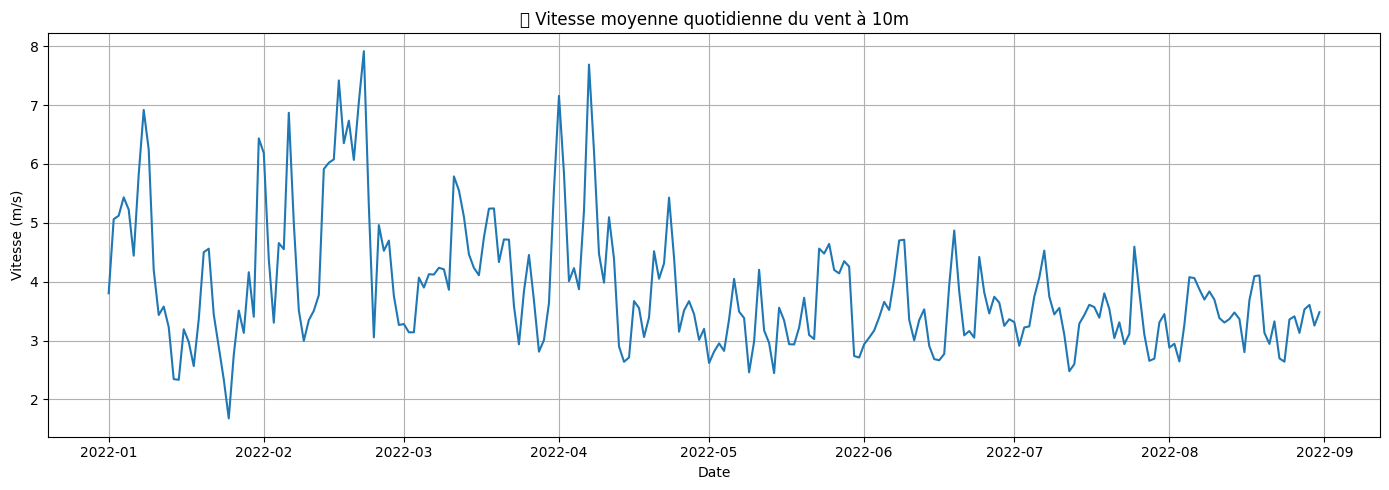

In [ ]:
import matplotlib.dates as mdates

#  Vitesse moyenne journalière

plt.figure(figsize=(14,5))
df_jour = df.groupby(df['time'].dt.date)['wind_speed_10m'].mean()
df_jour.plot()
plt.title(" Vitesse moyenne quotidienne du vent à 10m")
plt.xlabel("Date")
plt.ylabel("Vitesse (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29156\4279340261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='heure', y='wind_speed_10m', data=df, palette='Blues')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_29156\4279340261.py:7: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


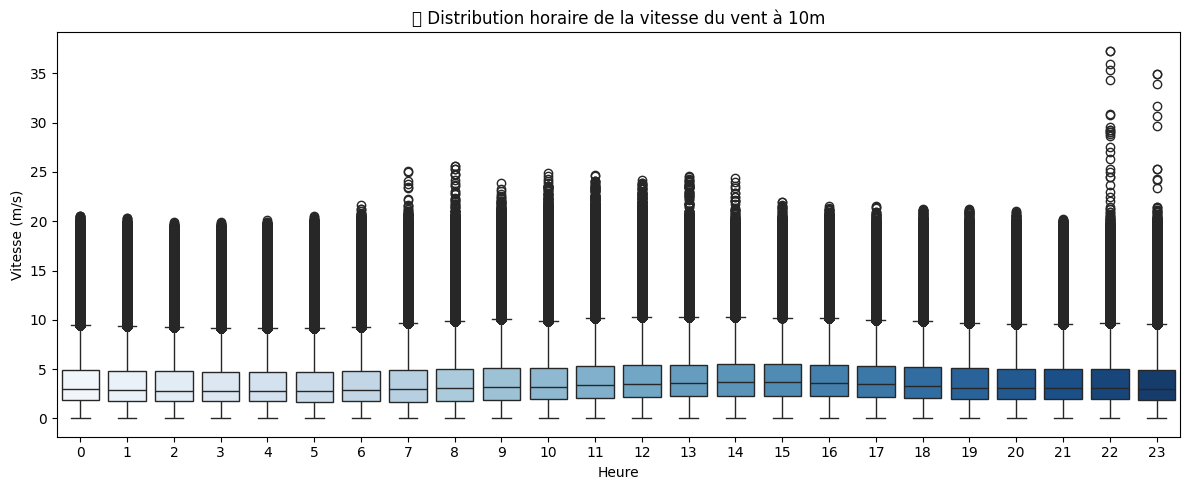

In [ ]:
#  Boxplot par heure (cycle journalier)

plt.figure(figsize=(12,5))
sns.boxplot(x='heure', y='wind_speed_10m', data=df, palette='Blues')
plt.title(" Distribution horaire de la vitesse du vent à 10m")
plt.xlabel("Heure")
plt.ylabel("Vitesse (m/s)")
plt.tight_layout()
plt.show()

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#### Heatmap des vitesses de vent à 10m en France métropolitaine 

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\geoaxes.py:527: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\geoaxes.py:524: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)


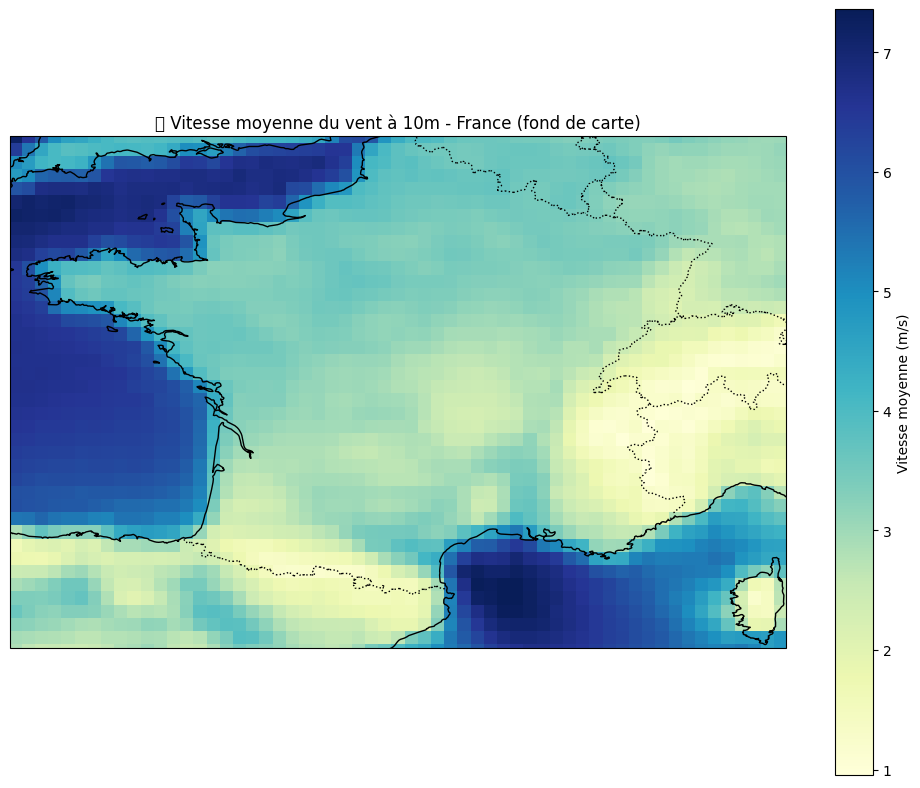

In [34]:
# Moyenne spatiale
df_moy = df.groupby(['latitude', 'longitude'])['wind_speed_10m'].mean().reset_index()

# Grille
lon = sorted(df_moy['longitude'].unique())
lat = sorted(df_moy['latitude'].unique())
wind = df_moy.pivot(index='latitude', columns='longitude', values='wind_speed_10m')

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-5.1, 9.6, 41.3, 51], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

c = ax.pcolormesh(lon, lat, wind.values, cmap='YlGnBu', shading='auto')
plt.colorbar(c, label='Vitesse moyenne (m/s)')
plt.title("🗺️ Vitesse moyenne du vent à 10m - France (fond de carte)")
plt.tight_layout()
plt.show()

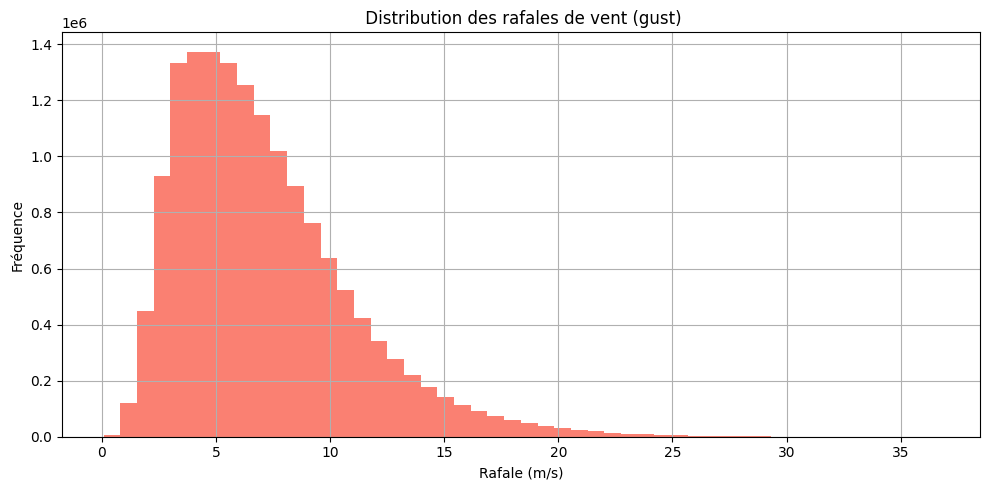

In [ ]:
#  Histogramme des rafales (gust)

plt.figure(figsize=(10,5))
df['gust'].hist(bins=50, color='salmon')
plt.title(" Distribution des rafales de vent (gust)")
plt.xlabel("Rafale (m/s)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29156\2017030229.py:10: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


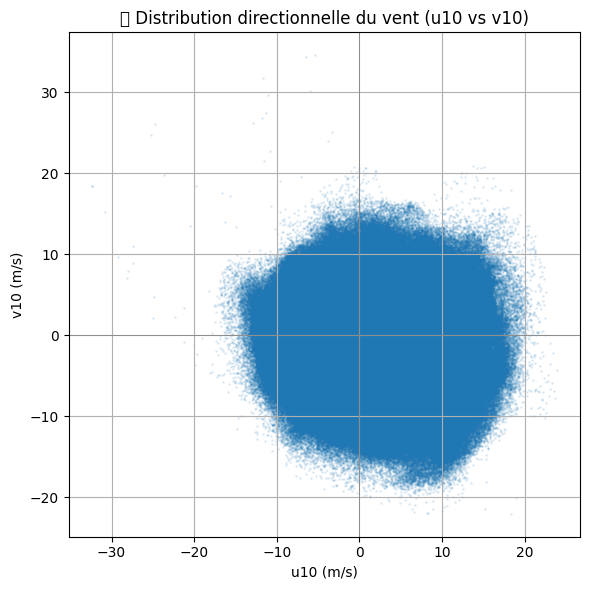

In [ ]:
# Nuage de points u10 vs v10

plt.figure(figsize=(6,6))
plt.scatter(df['u10'], df['v10'], alpha=0.1, s=1)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.title("Distribution directionnelle du vent (u10 vs v10)")
plt.xlabel("u10 (m/s)")
plt.ylabel("v10 (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()